In [549]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling, plotting

from matplotlib import cm
import pickle
import logomaker

In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]

In [269]:
experiment_id_idx = 0
experiment_id = experiment_ids[experiment_id_idx]

In [359]:
model = torch.load(f'saved/{experiment_id}_wd_0.1.pt', weights_only=False, map_location='cpu')

In [346]:
sequences, sequences_unique, counts, log_multinomial_factors = utils.sequences_counts_from_files(experiment_id, round_ids)

Finished round ARN
Finished round R01
Finished round R02N


In [500]:
sequences_unique_all, counts_unique = utils.group_rounds(sequences, sequences_unique, counts)

Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
Finished


In [502]:
train_valid_idx = torch.load(f'saved/train_test_split/{experiment_id}.pt')
idx_train = train_valid_idx['idx_train']
idx_valid = train_valid_idx['idx_valid']

In [506]:
((sequences_oh, total_reads, log_multinomial_factors), 
 (sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)) = \
    data_loading.split_train_test(sequences_unique_all, counts_unique, idx_train, idx_valid)

In [503]:
sequences_unique_valid_oh = utils.one_hot(sequences_unique_all[idx_valid])

In [348]:
sequences_oh = [utils.one_hot(s) for s in sequences]
total_reads = torch.tensor([len(s) for s in sequences])

In [357]:
from importlib import reload
reload(utils)
reload(callback)
reload(training)
reload(sampling)
reload(selex_distribution)
reload(energy_models)
reload(data_loading)

<module 'data_loading' from '/home/scrotti/Aptamer2025py/experiments/../data_loading.py'>

In [541]:
model_indep = torch.load(f'saved/{experiment_id}_indep_sites.pt', weights_only=False, map_location='cpu')

In [504]:
def log_likelihood_indep_sites(model_indep, sequences_oh, total_reads, log_multinomial_factors):
    models_t = [energy_models.IndepSites(model_indep.round_zero.h + t * model_indep.selection.modes[0].h) for t in range(model_indep.get_n_rounds())]
    log_likelihood_normaliz = (total_reads + log_multinomial_factors).sum().item()
    
    log_likelihood = 0.0
    for t in range(model_indep.get_n_rounds()):
        Lt = models_t[t].log_prob(sequences_oh[t]).mean()
        log_likelihood += (log_multinomial_factors[t] + total_reads[t] * Lt).item()
    
    return log_likelihood / log_likelihood_normaliz

In [511]:
nll_indep = - log_likelihood_indep_sites(model_indep, sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)
nll_indep

7.914001828346516

In [515]:
n_chains = 10**3
n_sweeps = 1
step = 1e-4

In [491]:
def estimate_nll_potts(sequences_oh, model, total_reads, log_multinomial_factors, n_chains, n_sweeps, step):
    batches = sequences_oh
    nll_potts = - training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
    return nll_potts

In [514]:
weight_decays = [0.0, 1e-2, 1e-1, 1e0]

models_potts = []
for weight_decay in weight_decays:
    model = torch.load(f'saved/{experiment_id}_wd_{weight_decay}.pt', weights_only=False, map_location='cpu')
    models_potts.append(model)

In [516]:
nll_potts = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh, model, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)
    nll_potts.append(nll)

nll_potts

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[7.112923894952228, 7.111228914101525, 7.593201299788933, 7.9071922937257035]

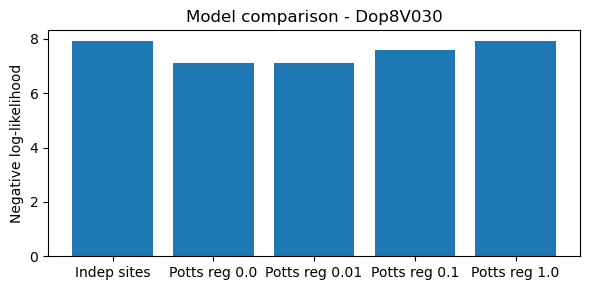

In [520]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls = [nll_indep] + nll_potts
ax.bar(ticks, nlls)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id}')
plt.tight_layout()

In [ ]:
n_samples = 20
steps = torch.logspace(-1, -5, 5)
nlls = []

for (i, step) in enumerate(steps):
    print(f'stepsize {step.item():0.3e}, {i+1}/{len(steps)}')
    nlls_step = []
    for s in range(n_samples):
        print(f'\t sample {s+1}/{n_samples}')
        nll_potts = estimate_nll_potts(sequences_oh, model, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
        nlls_step.append(nll_potts)
    nlls.append(nlls_step)

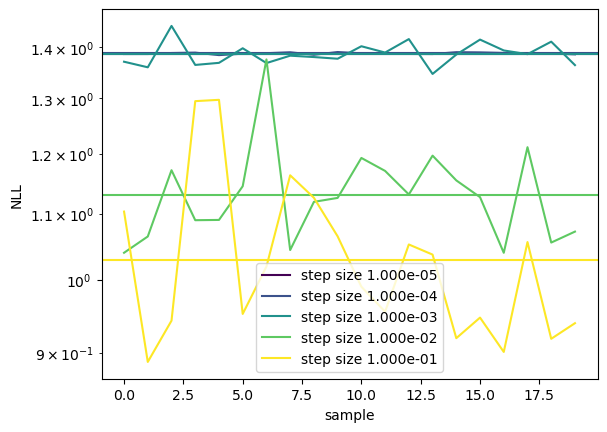

In [461]:
import matplotlib

cmap=matplotlib.cm.viridis
colors = [cmap(x) for x in np.flip(np.linspace(0, 1, len(steps)))]

fig, ax = plt.subplots()
for (i, step) in reversed(list(enumerate(steps))):
    ax.plot(nlls[i], label=f'step size {step.item():0.3e}', color=colors[i])
    ax.axhline(torch.tensor(nlls[i]).mean(), color=colors[i])
ax.legend()
ax.set_xlabel('sample')
ax.set_ylabel('NLL')
ax.set_yscale('log');

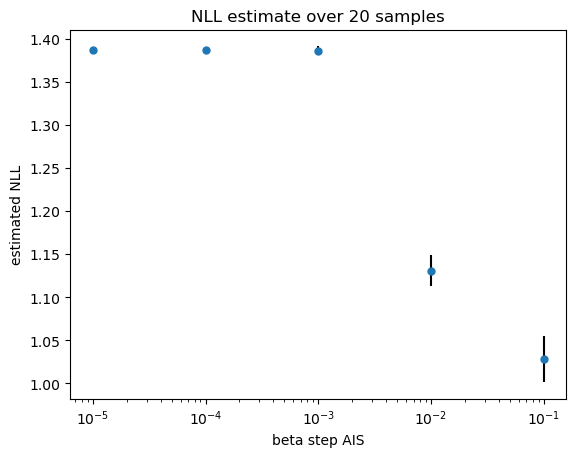

In [489]:
means = [torch.tensor(nlls[i]).mean().item() for i in range(len(steps))]
stds = [(torch.tensor(nlls[i]).std() / torch.sqrt(torch.tensor([len(nlls[i])]))).item() for i in range(len(steps))]

fig, ax = plt.subplots()
ax.errorbar(steps, means, yerr=stds, fmt='o', markersize=5, ecolor='black')
ax.set_xscale('log')
ax.set_xlabel('beta step AIS')
ax.set_ylabel('estimated NLL')
ax.set_title(f'NLL estimate over {n_samples} samples');

In [358]:
# filepath = f'/home/scrotti/Aptamer2025py/experiments/saved/pseudocount/indep_sites/{experiment_id}_0.00000000.pkl'
# with open(filepath, 'rb') as f:
#     params = pickle.load(f)[2]

# tr = tree.Tree()
# tr.add_node(-1, name = "R01")
# tr.add_node(0, name = "R02N")

# selected_modes = torch.BoolTensor(
#     [[1], [1]]
# )

# Ns0 = energy_models.IndepSites(params['bias_Ns0'])

# ps = selex_distribution.MultiModeDistribution(energy_models.IndepSites(params['bias_ps']), normalized=False)
# model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

# torch.save(model, f'saved/{experiment_id}_indep_sites.pt')

## Looking around wildtype

In [532]:
model = torch.load(f'saved/{experiment_id}_wd_0.01.pt', weights_only=False, map_location='cpu')

In [533]:
with open('./saved/wildtypes_sites.pkl', 'rb') as f:
    wts = pickle.load(f)

wt = wts[experiment_id_idx]
wt_oh = utils.one_hot(wt)
L = 45
q = 4

In [534]:
def hamming(x, y):
    L = x.size(-1)
    return (x != y).sum(dim=(-1))

In [535]:
def sequences_at_distance_1(wt):
    seq = []
    for i in range(L):
        delta = torch.zeros(L)
        # use itertools.product here to generalize to distance d
        for a in range(1, q):
            delta[i] = a
            s = torch.fmod(delta+wt, q)
            seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 1)
    return neigs

In [536]:
def sequences_at_distance_2(wt):
    seq = []
    for i in range(L):
        for j in range(L):
            if j != i:
                delta = torch.zeros(L)
                for a in range(1, q):
                    delta[i] = a
                    for b in range(1, q):
                        delta[j] = b
                        s = torch.fmod(delta+wt, q)
                        seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 2)
    return neigs

In [537]:
def plot_hist(model, wt, neigs, **kwargs):
    neighbors_oh = utils.one_hot(neigs)
    logps_neigs = - model.selection_energy_at_round(neighbors_oh, 1).detach()
    logps_wt = - model.selection_energy_at_round(wt_oh, 1).detach()
    fig, ax = plt.subplots(**kwargs)
    ax.hist(logps_neigs, bins=100, density=True)
    ax.axvline(x=logps_wt.item(), color='red', label="wildtype")
    ax.set_xlabel('logps'); ax.set_ylabel('frequency')
    ax.legend()
    return logps_neigs, logps_wt, fig, ax

In [638]:
def best_mutations(model, wt, neigs):
    neighbors_oh = utils.one_hot(neigs)
    logps_neigs = - model.selection_energy_at_round(neighbors_oh, 1).detach()
    logps_wt = - model.selection_energy_at_round(wt_oh, 1).detach()
    idx_best = logps_neigs >= logps_wt
    logps_best = (logps_neigs - logps_wt)[idx_best]
    perm = torch.argsort(logps_best)
    return torch.argmax(neighbors_oh[idx_best], dim=-1), perm, logps_best

In [639]:
neighbors_1 = sequences_at_distance_1(wt)
neighbors_2 = sequences_at_distance_2(wt)

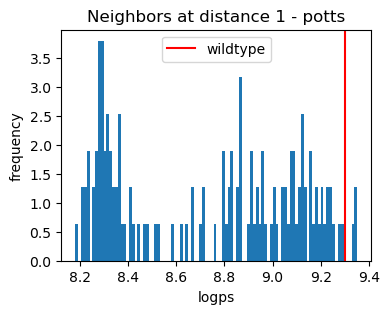

In [640]:
logps_neigs_1_potts, logps_wt_1_potts, fig, ax = plot_hist(model, wt, neighbors_1, figsize=(4,3))
ax.set_title('Neighbors at distance 1 - potts');

In [641]:
best_1_mutations_potts, perm_1_potts, logps_best_1_potts = best_mutations(model, wt, neighbors_1)

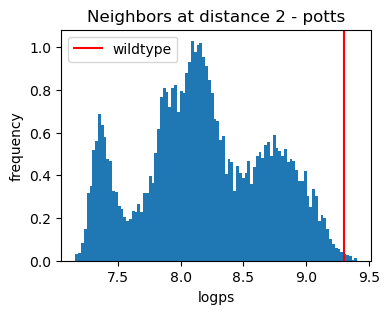

In [567]:
logps_neigs_2_potts, logps_wt_2_potts, fig, ax = plot_hist(model, wt, neighbors_2, figsize=(4,3))
ax.set_title('Neighbors at distance 2 - potts');

In [643]:
best_2_mutations_potts, perm_2_potts, logps_best_2_potts = best_mutations(model, wt, neighbors_2)

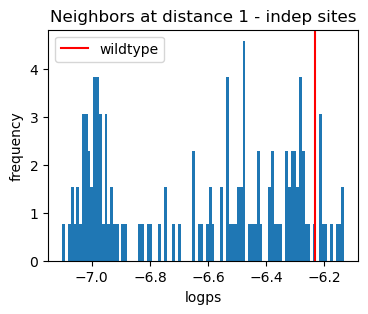

In [644]:
logps_neigs_1_indep, logps_wt_1_indep, fig, ax = plot_hist(model_indep, wt, neighbors_1, figsize=(4,3))
ax.set_title('Neighbors at distance 1 - indep sites');

In [645]:
best_1_mutations_indep, perm_1_indep, logps_best_1_indep = best_mutations(model_indep, wt, neighbors_1)

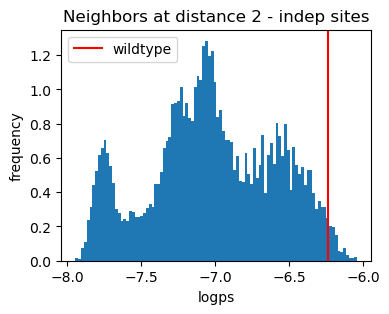

In [646]:
logps_neigs_1_indep, logps_wt_1_indep, fig, ax = plot_hist(model_indep, wt, neighbors_2, figsize=(4,3))
ax.set_title('Neighbors at distance 2 - indep sites');

In [647]:
best_2_mutations_indep, perm_2_indep, logps_best_2_indep = best_mutations(model_indep, wt, neighbors_2)

### Compare best mutations

In [680]:
mutation_idx = [(best_1_mutations_indep[i] != wt).nonzero().item() for i in range(best_1_mutations_indep.size(0))]
wt_letters = [utils.TOKENS_DNA[wt[idx].item()] for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [utils.TOKENS_DNA[best_1_mutations_indep[i][idx].item()] for (i, idx) in enumerate(mutation_idx)]
mutation_idx_unique_1_indep = torch.unique(torch.tensor(mutation_idx))
print('1 SITE - INDEP SITES')
mutations_1_indep = list(zip(mutation_idx, wt_letters, mutation_letters, logps_best_1_indep.tolist()))
mutations_1_indep

1 SITE - INDEP SITES


[(1, 'T', 'C', 0.09433650970458984),
 (10, 'G', 'T', 0.0027923583984375),
 (10, 'G', 'A', 0.02305889129638672),
 (10, 'G', 'C', 0.07545852661132812),
 (11, 'A', 'C', 0.06021595001220703),
 (11, 'A', 'T', 0.017914772033691406),
 (12, 'C', 'G', 0.027082443237304688),
 (12, 'C', 'A', 0.017800331115722656),
 (20, 'T', 'A', 0.1007680892944336),
 (20, 'T', 'G', 0.019983768463134766),
 (24, 'G', 'A', 0.03923320770263672),
 (27, 'A', 'T', 0.08201408386230469)]

In [681]:
mutation_idx = [(best_1_mutations_potts[i] != wt).nonzero().item() for i in range(best_1_mutations_potts.size(0))]
wt_letters = [utils.TOKENS_DNA[wt[idx].item()] for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [utils.TOKENS_DNA[best_1_mutations_potts[i][idx].item()] for (i, idx) in enumerate(mutation_idx)]
print('1 SITE - POTTS')
mutations_1_potts = list(zip(mutation_idx, wt_letters, mutation_letters, logps_best_1_potts.tolist()))
mutations_1_potts

1 SITE - POTTS


[(1, 'T', 'C', 0.03645610809326172),
 (20, 'T', 'A', 0.042418479919433594),
 (27, 'A', 'T', 0.052748680114746094)]

In [682]:
mutation_idx = [tuple((best_2_mutations_indep[i] != wt).nonzero().squeeze().tolist()) for i in range(best_2_mutations_indep.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_2_mutations_indep[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('2 SITE - INDEP SITES')
mutations_2_indep = list(zip(mutation_idx, wt_letters, mutation_letters, logps_best_2_indep.tolist()))

2 SITE - INDEP SITES


In [686]:
mutation_idx = [tuple((best_2_mutations_potts[i] != wt).nonzero().squeeze().tolist()) for i in range(best_2_mutations_potts.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_2_mutations_potts[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('2 SITE - POTTS')
mutations_2_potts = list(zip(mutation_idx, wt_letters, mutation_letters, logps_best_2_potts.tolist()))
len(mutations_2_potts)

2 SITE - POTTS


34

In [689]:
mutations_2_potts

[((1, 10), ('T', 'G'), ['C', 'C'], 0.04056262969970703),
 ((1, 11), ('T', 'A'), ['C', 'C'], 0.01888751983642578),
 ((1, 12), ('T', 'C'), ['C', 'A'], 0.0039539337158203125),
 ((1, 20), ('T', 'T'), ['C', 'A'], 0.08883285522460938),
 ((1, 24), ('T', 'G'), ['C', 'A'], 0.027586936950683594),
 ((1, 27), ('T', 'A'), ['C', 'T'], 0.0952463150024414),
 ((1, 10), ('T', 'G'), ['C', 'C'], 0.04056262969970703),
 ((10, 20), ('G', 'T'), ['C', 'A'], 0.042572975158691406),
 ((10, 27), ('G', 'A'), ['A', 'T'], 0.000270843505859375),
 ((10, 27), ('G', 'A'), ['C', 'T'], 0.06488323211669922),
 ((1, 11), ('T', 'A'), ['C', 'C'], 0.01888751983642578),
 ((11, 20), ('A', 'T'), ['C', 'A'], 0.02008056640625),
 ((11, 27), ('A', 'A'), ['C', 'T'], 0.041558265686035156),
 ((11, 27), ('A', 'A'), ['T', 'T'], 0.008876800537109375),
 ((1, 12), ('T', 'C'), ['C', 'A'], 0.0039539337158203125),
 ((12, 27), ('C', 'A'), ['G', 'T'], 0.004765510559082031),
 ((12, 27), ('C', 'A'), ['A', 'T'], 0.025534629821777344),
 ((1, 20), ('T',

In [688]:
mutation_idx_unique_1_indep

tensor([ 1, 10, 11, 12, 20, 24, 27])

In [687]:
double_good_mutations = []

for m in mutations_2_potts:
    i, j = m[0]
    if (i in mutation_idx_unique_1_indep) and (j in mutation_idx_unique_1_indep):
        double_good_mutations.append(m)
len(double_good_mutations)

34

In [655]:
perm_2_indep, perm_2_potts

(tensor([ 52, 270, 147, 255,   4,  55, 276,  75, 110, 246, 155,  47,  38, 206,
         274,  73, 214,  64,  57,   6,  44,  81, 264, 114,  60, 211, 165, 134,
         293, 248, 140, 195,  27, 204, 185, 259, 213,  62,  41,   1,  69, 125,
         119,  17, 271,  53, 266, 295, 103, 193,  67,   9, 124,  59, 180,  99,
          51, 250,  37, 122,  65,   7, 208,  48,  72, 217, 290, 201, 139, 194,
         160,  93, 245,  30, 130,  86, 186, 286, 221, 105,  70, 215,  97, 159,
         192, 102,  42,   2, 263,  32, 247, 239,  84,  68,  13,  79,  83,  58,
          92, 156, 176, 284,  80,  36, 289, 200,  49, 209, 242, 265,  25, 190,
         182, 138,  21, 178, 275,  74, 268,  34, 137, 167, 191, 101, 123,  46,
          63, 273,  90, 129, 269,  40, 233, 172, 228, 145, 198, 238, 234, 183,
          95, 161,  88, 131, 251, 111, 288, 199,  19, 153, 222, 107, 281, 150,
         189,  24, 164, 136,  66,   8, 232, 169, 181, 100,   5,  56, 230, 170,
          35,   0,  94, 157, 237, 197,  45,  82, 216

In [627]:
torch.all(torch.tensor([m in mutations_2_indep for m in mutations_2_potts]))

tensor(True)

In [551]:
h_indep = model_indep.selection.modes[0].set_zerosum_gauge().h.clone().detach()
hamming(h_indep.argmax(1), wt)

tensor(7)

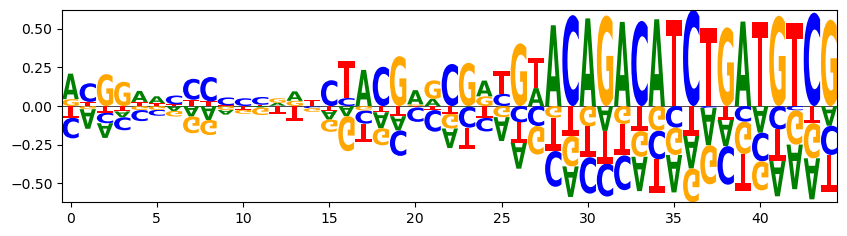

In [552]:
logomaker.Logo(pd.DataFrame(h_indep, columns=list(utils.TOKENS_DNA)))

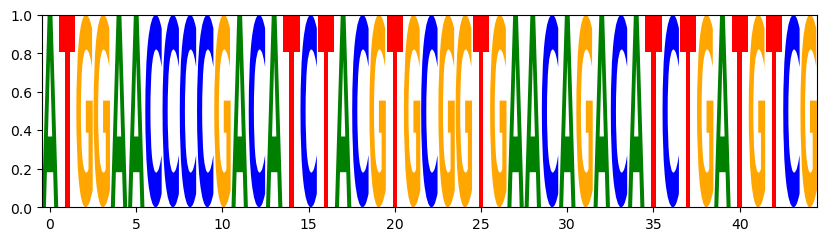

In [554]:
logomaker.Logo(pd.DataFrame(wt_oh, columns=list(utils.TOKENS_DNA)))